In [ ]:
cd '/home/dpirvu/DarkPhoton/'

In [2]:
import os,sys
sys.path.remove('/home/dpirvu/DarkPhotonxunWISE/hmvec-master')
sys.path.append('/home/dpirvu/DarkPhoton/hmvec-master/')
sys.path.append('/home/dpirvu/python_stuff/')
print(sys.path)

import hmvec as hm

from plotting import *
from compute_power_spectra import *
from params import *
from scipy.optimize import minimize
from scipy.stats import chi2

%matplotlib inline

np_load_old = np.load
np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True, **k)

['/home/dpirvu/DarkPhoton', '/cm/shared/apps/python/python37/lib/python37.zip', '/cm/shared/apps/python/python37/lib/python3.7', '/cm/shared/apps/python/python37/lib/python3.7/lib-dynload', '', '/home/dpirvu/.local/lib/python3.7/site-packages', '/cm/shared/apps/python/python37/lib/python3.7/site-packages', '/cm/shared/apps/python/python37/lib/python3.7/site-packages/IPython/extensions', '/home/dpirvu/.ipython', '/home/dpirvu/DarkPhoton/hmvec-master/', '/home/dpirvu/python_stuff/']


### FIRAS constraint

In [3]:
COBE = np.genfromtxt('./data/FIRAS.txt')
print(np.shape(COBE))

COBE = COBE[:,:]
print(np.shape(COBE))


(43, 5)
(43, 5)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


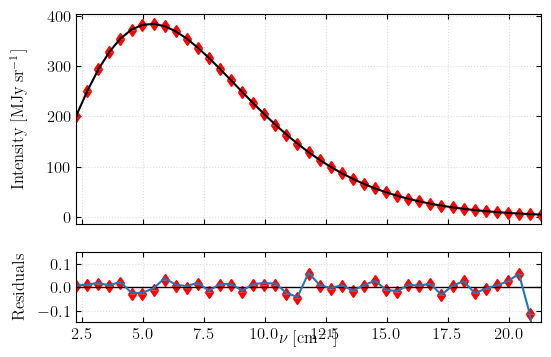

In [4]:
fig = plt.figure(figsize=(6,4))
gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1]) 

ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1], sharex = ax0)
beautify(ax1, times=-70)
beautify(ax0, times=-70)

ax0.errorbar(COBE[:,0], COBE[:,1], yerr=COBE[:,3]*1e-3, color='k', ecolor='r', \
            capthick=1, linewidth=1, fmt='None', uplims=True, lolims=True, label=r'$\rm COBE/FIRAS \; data$')

# data minus residual = blackbody
ax0.plot(COBE[:,0], COBE[:,1]-COBE[:,2]*1e-3, color='k', label=r'$\rm Blackbody \; T_{\rm CMB} = 2.725K$')

ax1.errorbar(COBE[:,0], COBE[:,1]-BBf(frq(COBE[:,0])))

ax1.errorbar(COBE[:,0], COBE[:,2]*1e-3, yerr=COBE[:,3]*1e-3, color='k', ecolor='r', \
                        capthick=1, linewidth=1, fmt='None', uplims=True, lolims=True,)


ax0.set_ylabel(r'$\rm Intensity \; [MJy \; sr^{-1}]$')
ax1.set_xlabel(r'$\rm \nu \; [cm^{-1}]$')
ax1.set_ylabel(r'$\rm Residuals$')

ax1.axhline(0, ls='-', color='k', alpha=1, linewidth=1)
ax1.set_ylim((-0.15,0.15))
ax1.set_xlim((COBE[0,0],COBE[-1,0]))

plt.setp(ax0.get_xticklabels(), visible=False)
yticks = ax1.yaxis.get_major_ticks()
yticks[-1].label1.set_visible(False)
plt.show()

/home/dpirvu/DarkPhoton/hmvec-master/params.py:47: RuntimeWarning: invalid value encountered in true_divide
  BBf = lambda frq: 1e26/1e6 * (2.*frq**3.*hplanck)/cligth**2. / (np.exp(frq * hplanck/kboltzmann/TFIRAS) - 1.)


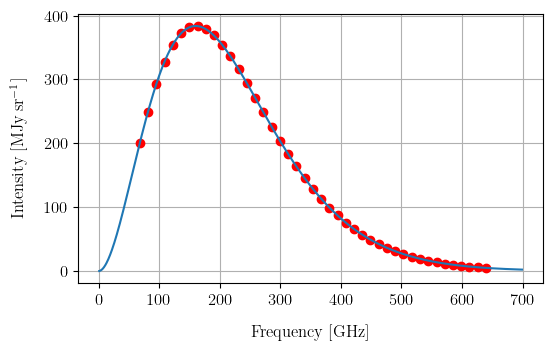

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(6,3.5))
plt.plot(frq(COBE[:,0])/1e9, BBf(frq(COBE[:,0])), 'ro')

freqs = np.linspace(0, 699, 700)
plt.plot(freqs, BBf(freqs*1e9))
plt.xlabel(r'$\rm Frequency \; [GHz]$')
plt.ylabel(r'$\rm Intensity \; [MJy \; sr^{-1}]$')
plt.grid(); plt.show()


In [6]:
frq(COBE[:,0])/1e9

array([ 68.05288797,  81.54354858,  95.33400164, 108.82466225,
       122.31532286, 136.10577593, 149.59643654, 163.38688961,
       176.87755022, 190.36821083, 204.1586639 , 217.64932451,
       231.13998512, 244.93043819, 258.4210988 , 272.21155186,
       285.70221247, 299.19287308, 312.98332615, 326.47398676,
       339.96464737, 353.75510044, 367.24576105, 381.03621412,
       394.52687473, 408.01753534, 421.80798841, 435.29864902,
       448.78930963, 462.57976269, 476.0704233 , 489.86087637,
       503.35153698, 516.84219759, 530.63265066, 544.12331127,
       557.91376434, 571.40442495, 584.89508556, 598.68553863,
       612.17619924, 625.66685985, 639.45731291])

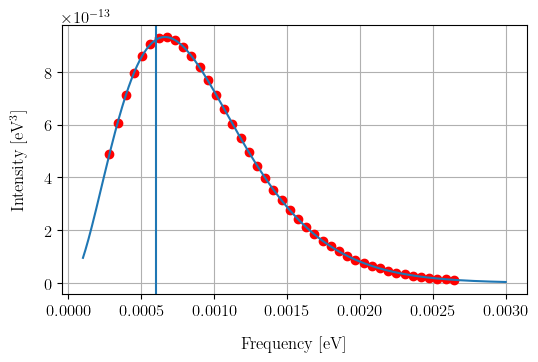

In [7]:
freqs = frq(COBE[:,0]) # Hz
freqs = freqs/1e9 # GHz
freqs = ghztoev(freqs) # eV

fig, ax = plt.subplots(1, 1, figsize=(6,3.5))
plt.plot(freqs, BBω(freqs), 'ro')
plt.axvline(ghztoev(145))

freqsext = np.linspace(1e-4, 3e-3, 1000)
plt.plot(freqsext, BBω(freqsext))
plt.xlabel(r'$\rm Frequency \; [eV]$')
plt.ylabel(r'$\rm Intensity \; [eV^3]$')
plt.grid(); plt.show()


In [8]:
# we want the residual of the CMB blackbody to be greater than the screening due to dark photons
# res < ϵ^2 τav T0
firasdomainEV = ghztoev(frq(COBE[:,0])/1e9)

FIRASdata = np.zeros(np.shape(COBE))
for cind, col in enumerate([COBE[:,0], COBE[:,1], COBE[:,2], COBE[:,3], COBE[:,4]]):
    if cind==0:
        FIRASdata[:, cind] = firasdomainEV
    if cind==1:
        FIRASdata[:, cind] = col/(1e26/1e6*(2.*frq(COBE[:,0])**3.*hplanck)/cligth**2.) * firasdomainEV**3. / (2.*np.pi**2.)
    else:
        FIRASdata[:, cind] = col/(1e26/1e3*(2.*frq(COBE[:,0])**3.*hplanck)/cligth**2.) * firasdomainEV**3. / (2.*np.pi**2.)


In [9]:
MAMWlimit = np.load('./data/MWmassconstraint.npy')
MAMW_rscalelimit = np.load('./data/MWrscale_massconstraint.npy')
rscaleMW = np.load('./data/MWscaleradius.npy')


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(100,)
(100,)
8.148754173103232e-12


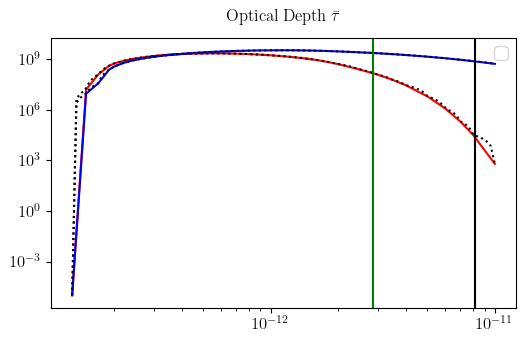

In [10]:
old_masses, loadedGAS = np.load('./data/new_fullmonopole_gas_z6.npy')
loadedGAS[0] = 1e-5

f = scp.interpolate.interp1d(old_masses, loadedGAS)
masss = np.geomspace(old_masses[0], old_masses[-1], 100)
constraint = f(masss)
print(np.shape(constraint))

fig, ax = plt.subplots(1, 1, figsize=(6,3.5))
plt.plot(old_masses, loadedGAS, 'r')
plt.plot(masss, constraint, ':k')

old_masses_NFW, loadedNFW = np.load('./data/new_fullmonopole_NFW_z6.npy')
loadedNFW[0] = 1e-5

f = scp.interpolate.interp1d(old_masses_NFW, loadedNFW)
masss_NFW = np.geomspace(old_masses_NFW[0], old_masses_NFW[-1], 100)
constraint_NFW = f(masss_NFW)
print(np.shape(constraint))

plt.plot(old_masses_NFW, loadedNFW, 'b')
plt.plot(masss_NFW, constraint_NFW, ':k')

print(MAMWlimit)
plt.axvline(MAMW_rscalelimit, color='g')
plt.axvline(MAMWlimit, color='k')
ax.set_yscale('log')

plt.title(r'$\rm Optical \; Depth \; \bar{\tau}$')
plt.xscale('log'); plt.legend(); plt.show()


/cm/shared/apps/python/python37/lib/python3.7/site-packages/ipykernel_launcher.py:48: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "rasterize" which is no longer supported as of 3.3 and will become an error in 3.6


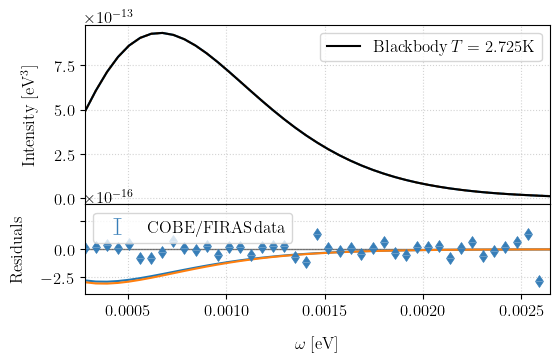

In [11]:
def plot_residual(xdata, ydata, resdata, mind0, mind, masss, ax0, ax1):
    ax0.grid(ls=':', color='darkgray', alpha=0.5); ax1.grid(ls=':', color='darkgray', alpha=0.5)
    ax1.axhline(0, ls='-', color='k', alpha=0.5, linewidth=1)

    for vv, vec in enumerate(ydata):
        ax0.plot(xdata, vec, ls=(':' if vv!=0 else '-'))
    for vv, vec in enumerate(resdata):
        lab = (r'$m_{{A^\prime}}$'+sci_notation(masss[vv][mind0])+r'eV' if vv==0 else None)
        ax1.plot(xdata, vec)
    plt.setp(ax0.get_xticklabels(), visible=False)
    yticks = ax1.yaxis.get_major_ticks(); yticks[-1].label1.set_visible(False)

    ax1.set_xlabel(r'$\rm \omega \; [eV]$'); ax0.set_ylabel(r'$\rm Intensity \; [eV^3]$')
    ax1.set_ylabel(r'$\rm Residuals$')
    return fig

cych = ['#377eb8', '#ff7f00', 'forestgreen', '#f781bf', '#a65628', '#984ea3', '#999999', '#e41a1c', '#dede00']
fig = plt.figure(figsize=(6,3.5))
gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1]) 
plt.subplots_adjust(hspace=.0)
ax0 = plt.subplot(gs[0]); ax1 = plt.subplot(gs[1], sharex = ax0)


mind0 = 27
mind = 27
epsilon = 8e-7
baseline = ghztoev(30)

distGAS = epsilon**2. * constraint[mind0]    * baseline / firasdomainEV
distNFW = epsilon**2. * constraint_NFW[mind] * baseline / firasdomainEV
screenedGAS = BBω(firasdomainEV) * (1. - distGAS)
screenedNFW = BBω(firasdomainEV) * (1. - distNFW)

null = FIRASdata[:,1] - FIRASdata[:,1]
δIGAS = screenedGAS - BBω(firasdomainEV)
δINFW = screenedNFW - BBω(firasdomainEV)

plot_residual(firasdomainEV, [screenedGAS, screenedNFW], [δIGAS, δINFW], mind0, mind, [masss, masss_NFW], ax0, ax1)

ax0.plot(firasdomainEV, FIRASdata[:,1], color='k', label=r'${\rm Blackbody \,} T=2.725 {\rm K}$')
ax1.errorbar(firasdomainEV, FIRASdata[:,2], yerr=FIRASdata[:,3], color='k', ecolor=cych[0], \
                        capthick=0.5, linewidth=1, fmt='None', uplims=True, \
                        lolims=True, label=r'${\rm COBE/FIRAS \, data}$')
ax0.legend()
ax1.legend()
ax1.set_xlim((firasdomainEV[0],firasdomainEV[-1]))
ax1.set_ylim((-0.4e-15,0.4e-15))
plt.savefig('./plots/blackbody_change.pdf', rasterize=True)
plt.show()


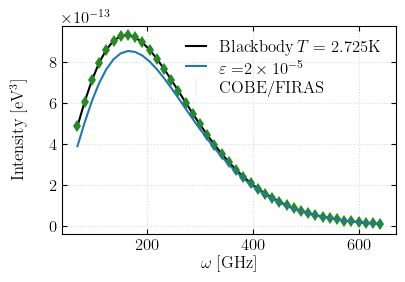

In [12]:
cych = ['#377eb8', '#ff7f00', 'forestgreen', '#f781bf', '#a65628', '#984ea3', '#999999', '#e41a1c', '#dede00']
fig, ax0 = plt.subplots(1, 1, figsize=(4.3,2.7))

mind0 = 27
mind = 27
epsilon = 1.5e-5
baseline = ghztoev(30)

distGAS = epsilon**2. * constraint[mind0]    * baseline / firasdomainEV
distNFW = epsilon**2. * constraint_NFW[mind] * baseline / firasdomainEV
screenedGAS = BBω(firasdomainEV) * (1. - distGAS)
screenedNFW = BBω(firasdomainEV) * (1. - distNFW)

null = FIRASdata[:,1] - FIRASdata[:,1]
δIGAS = screenedGAS - BBω(firasdomainEV)
δINFW = screenedNFW - BBω(firasdomainEV)

firasdomainGHz = frq(COBE[:,0])/1e9

ax0.plot(firasdomainGHz, FIRASdata[:,1], color='k', label=r'${\rm Blackbody \,} T=2.725 {\rm K}$')

ax0.errorbar(firasdomainGHz, BBω(firasdomainEV), yerr=FIRASdata[:,3], color='k', ecolor='forestgreen', \
            capthick=0.01, lw=0.5, elinewidth=0.1, fmt='None', markerfacecolor=None, uplims=True, lolims=True, label=r'$\rm COBE/FIRAS$')

ax0.plot(firasdomainGHz, screenedGAS, label=r'$\varepsilon=$'+sci_notation(epsilon,0))

ax0.set_xlabel(r'$\rm \omega \; [GHz]$')
ax0.set_ylabel(r'$\rm Intensity \; [eV^3]$')
beautify(ax0, times=-70)
plt.savefig('./plots/blackbody_change_nores.pdf')
plt.show()


In [13]:
#eplist = list(set(np.geomspace(4e-6, 1e-5, 200).tolist() + np.linspace(1e-5, 1e-4, 50).tolist()))
#eplist = np.concatenate((np.linspace(1.4e-6, 9e-6, 50), np.linspace(9e-6, 1e-4, 10)[1:]), axis=0)
eplist = np.geomspace(1.e-6, 1e-3, 300)

scrGAS = np.zeros((len(masss), len(eplist), len(COBE)))
scrNFW = np.zeros((len(masss_NFW), len(eplist), len(COBE)))

BBωT = lambda T, omg: (omg**3.)/(2.*np.pi**2.) / (np.exp(omg/K2eV(T)) - 1.)

for mind, MA in enumerate(masss):
    for eind, epsilon in enumerate(eplist):
        scrGAS[mind,eind] = epsilon**2. * constraint[mind]     * baseline / firasdomainEV

for mind, MA in enumerate(masss_NFW):
    for eind, epsilon in enumerate(eplist):
        scrNFW[mind,eind] = epsilon**2. * constraint_NFW[mind] * baseline / firasdomainEV


In [14]:
Ndof = len(COBE)-1
Ndof_inv = 1./Ndof

chisqfid = lambda T:             Ndof_inv * np.sum(((FIRASdata[:,1] - BBωT(T, firasdomainEV)                       )/FIRASdata[:,3])**2.)
chisqGAS = lambda T, mind, eind: Ndof_inv * np.sum(((FIRASdata[:,1] - BBωT(T, firasdomainEV)*(1.-scrGAS[mind,eind]))/FIRASdata[:,3])**2.)
chisqNFW = lambda T, mind, eind: Ndof_inv * np.sum(((FIRASdata[:,1] - BBωT(T, firasdomainEV)*(1.-scrNFW[mind,eind]))/FIRASdata[:,3])**2.)

resnull = minimize(chisqfid, x0=TFIRAS, method='Powell', tol=1e-15)
chisq0 = chisqfid(TFIRAS)
print(TFIRAS, resnull.x, chisqfid(TFIRAS), resnull.fun)


2.725 [2.72501553] 1.17368061718177 1.0737243313348372


In [15]:
gofdataGAS = np.zeros((len(masss), len(eplist)))
gofdataNFW = np.zeros((len(masss_NFW), len(eplist)))

for mind, MA in enumerate(masss):
    for eind, epsilon in enumerate(eplist):
        resGAS = minimize(chisqGAS, args=(mind, eind), x0=TFIRAS, method='Powell', tol=1e-15)
        gofdataGAS[mind,eind] = resGAS.fun

for mind, MA in enumerate(masss_NFW):
    for eind, epsilon in enumerate(eplist):
        resNFW = minimize(chisqNFW, args=(mind, eind), x0=TFIRAS, method='Powell', tol=1e-15)
        gofdataNFW[mind,eind] = resNFW.fun


/cm/shared/apps/python/python37/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: overflow encountered in exp
  


In [16]:
bound1 = chi2.ppf(q=0.95, df=Ndof)
bound2 = chi2.ppf(q=0.99, df=Ndof)
print(bound1, bound2)

x = masss
y = eplist
xx, yy = np.meshgrid(x, y)

contGAS95 = (gofdataGAS <= bound1)
contGAS99 = (gofdataGAS <= bound2)

xNFW = masss_NFW
yNFW = eplist
xxNFW, yyNFW = np.meshgrid(xNFW, yNFW)

contNFW95 = (gofdataNFW <= bound1)
contNFW99 = (gofdataNFW <= bound2)


58.12403768086803 66.20623628399322


/cm/shared/apps/python/python37/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: The following kwargs were not used by contour: 'aspect'
  
/cm/shared/apps/python/python37/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: The following kwargs were not used by contour: 'aspect'
  after removing the cwd from sys.path.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


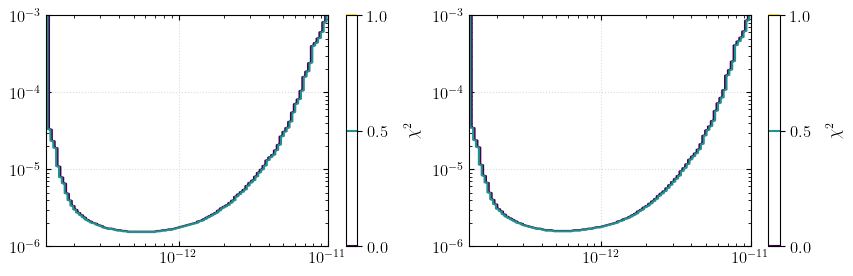

/cm/shared/apps/python/python37/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: The following kwargs were not used by contour: 'aspect'
  del sys.path[0]
/cm/shared/apps/python/python37/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: The following kwargs were not used by contour: 'aspect'
  from ipykernel import kernelapp as app
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


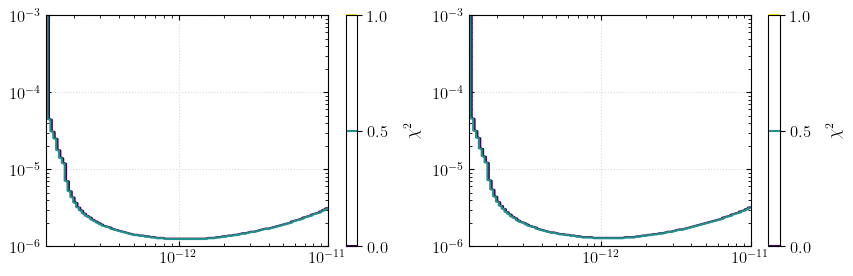

In [17]:
fig, ax = plt.subplots(1, 2, figsize=(10,3))
im1 = ax[0].contour(xx, yy, contGAS95.T, levels=1, origin='lower', aspect='auto')
plt.colorbar(im1, ax=ax[0], label=r'$\chi^2$')
im1 = ax[1].contour(xx, yy, contGAS99.T, levels=1, origin='lower', aspect='auto')
plt.colorbar(im1, ax=ax[1], label=r'$\chi^2$')
for axx in ax:
    axx.set_xscale('log')
    axx.set_yscale('log')
beautify(ax)
plt.show()

fig, ax = plt.subplots(1, 2, figsize=(10,3))
im1 = ax[0].contour(xx, yy, contNFW95.T, levels=1, origin='lower', aspect='auto')
plt.colorbar(im1, ax=ax[0], label=r'$\chi^2$')
im1 = ax[1].contour(xx, yy, contNFW99.T, levels=1, origin='lower', aspect='auto')
plt.colorbar(im1, ax=ax[1], label=r'$\chi^2$')
for axx in ax:
    axx.set_xscale('log')
    axx.set_yscale('log')
beautify(ax)
plt.show()

In [18]:
def find_first_one_index(arr):
    for i, val in enumerate(arr):
        if val:
            return i
    return -1  # Return -1 if no '1' is found


/cm/shared/apps/python/python37/lib/python3.7/site-packages/ipykernel_launcher.py:30: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "rasterize" which is no longer supported as of 3.3 and will become an error in 3.6


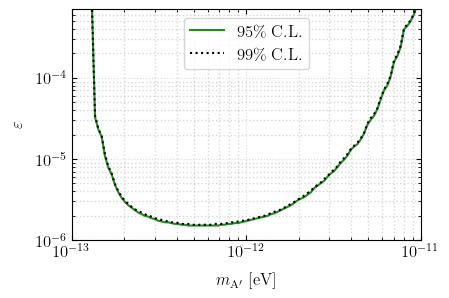

In [19]:
fig, ax = plt.subplots(1,1, figsize = (4.5,3))

reio = contGAS95
coord, limit = np.zeros((2, len(masss)))
for mm, arr in enumerate(reio):
    first_true_index = find_first_one_index(arr[::-1])
    coord[mm] = masss[mm]
    limit[mm] = eplist[::-1][first_true_index]
plt.plot(coord, limit, ls='-', label=r'$95\% \; \rm C.L.$', color='forestgreen')

reio = contGAS99
coord, limit = np.zeros((2, len(masss)))
for mm, arr in enumerate(reio):
    first_true_index = find_first_one_index(arr[::-1])
    coord[mm] = masss[mm]
    limit[mm] = eplist[::-1][first_true_index]
l1, = plt.plot(coord, limit, ls=':', label=r'$99\% \; \rm C.L.$', color='k')
np.save('./data/gas_contour.npy', [coord, limit])

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylabel(r'$\varepsilon$')
ax.set_xlabel(r'$m_{{\rm A}^{\prime}} \; [{\rm eV}]$')
ymin, ymax = ax.get_ylim()
ax.set_ylim((1e-6, 7e-4))
ax.set_xlim((1e-13, 1e-11))
beautify(ax, times=-90)
plt.legend()
ax.grid(True, which='minor', alpha=0.5, lw=1, ls=':')
plt.savefig('./plots/gas_firascontour.pdf', rasterize=True)
plt.show()


/cm/shared/apps/python/python37/lib/python3.7/site-packages/ipykernel_launcher.py:30: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "rasterize" which is no longer supported as of 3.3 and will become an error in 3.6


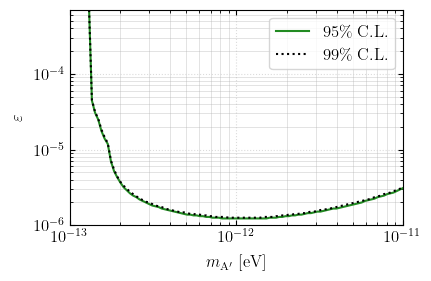

In [20]:
fig, ax = plt.subplots(1,1, figsize = (4.3,2.8))

reio = contNFW95
coord, limit = np.zeros((2, len(masss_NFW)))
for mm, arr in enumerate(reio):
    first_true_index = find_first_one_index(arr[::-1])
    coord[mm] = masss_NFW[mm]
    limit[mm] = eplist[::-1][first_true_index]
plt.plot(coord, limit, ls='-', label=r'$95\% \; \rm C.L.$', color='forestgreen')

reio = contNFW99
coord, limit = np.zeros((2, len(masss_NFW)))
for mm, arr in enumerate(reio):
    first_true_index = find_first_one_index(arr[::-1])
    coord[mm] = masss_NFW[mm]
    limit[mm] = eplist[::-1][first_true_index]
l1, = plt.plot(coord, limit, ls=':', label=r'$99\% \; \rm C.L.$', color='k')
np.save('./data/NFW_contour.npy', [coord, limit])

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylabel(r'$\varepsilon$')
ax.set_xlabel(r'$m_{{\rm A}^{\prime}} \; [{\rm eV}]$')
ymin, ymax = ax.get_ylim()
ax.set_ylim((1e-6, 7e-4))
ax.set_xlim((1e-13, 1e-11))
beautify(ax, times=-90)
plt.legend()
ax.grid(True, which='minor', alpha=0.5, lw=0.5)
plt.savefig('./plots/NFW_firascontour.pdf', rasterize=True)
plt.show()
